# Plots associated with the PSD models

We now have the smoothed PSDs - so we look at the 

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('../paper.mplstyle')
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

from pycbc.types import load_frequencyseries
from pycbc.psd.lisa_pre_merger import generate_pre_merger_psds


/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
# load the PSD files

A_psd = load_frequencyseries('A_sangria_hm_PSD.txt')
A_psd_smoothed = load_frequencyseries('A_sangria_hm_SMOOTHED_PSD.txt')
E_psd = load_frequencyseries('E_sangria_hm_PSD.txt')
E_psd_smoothed = load_frequencyseries('E_sangria_hm_SMOOTHED_PSD.txt')

raw = [A_psd, E_psd]
raw_smoothed = [A_psd_smoothed, E_psd_smoothed]
raw_labels = ['A','E']


In [3]:
def to_ts(psd_in):
    inv = 1 / (psd_in ** 0.5)
    inv = inv.astype(np.complex128)
    # inv[0] = 0

    ts = inv.to_timeseries()
    # This bit makes it easier for plotting:
    ts._epoch = 0
    ts.roll(int(5 * 86400 * ts.sample_rate))
    ts._epoch = -5 * 86400
    return ts

In [4]:
A_ts = to_ts(A_psd)
A_smooth_ts = to_ts(A_psd_smoothed)

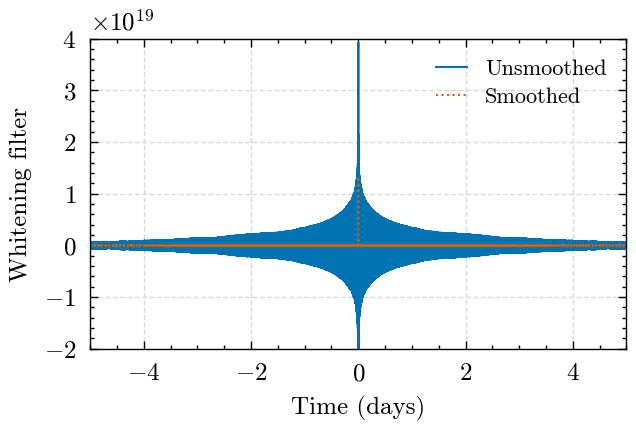

In [5]:
fig, ax = plt.subplots(1)
ax.plot(A_ts.sample_times / 86400., A_ts, label='Unsmoothed', c=cycle[0])
ax.plot(A_smooth_ts.sample_times / 86400., A_smooth_ts, ':', label='Smoothed', c=cycle[3])

ax.legend(loc='upper right')
ax.set_ylim(-2e19,4E19)
ax.set_xlim(-5,5)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Whitening filter')
ax.grid(zorder=-100)

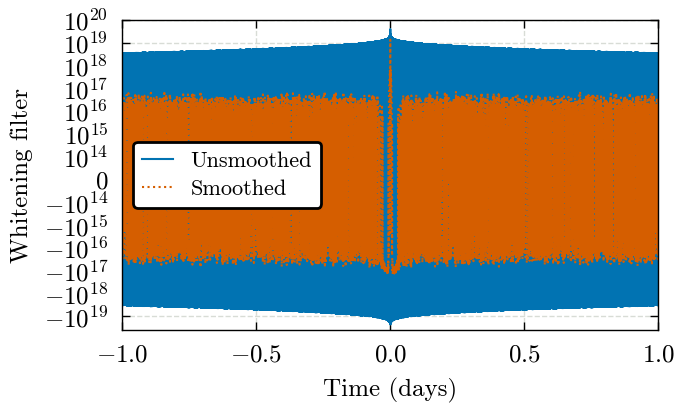

In [6]:
fig, ax = plt.subplots(1)

ax.plot(A_ts.sample_times / 86400., A_ts, label='Unsmoothed', c=cycle[0])
ax.plot(A_smooth_ts.sample_times / 86400., A_smooth_ts, ':', label='Smoothed', c=cycle[3])
ax.grid(zorder=-100)
ax.legend(loc='center left', facecolor='white', framealpha=1, edgecolor='k')

ax.set_ylabel('Whitening filter')
ax.set_ylim(-4E19,1E20)
ax.set_xlim(-1,1)
ax.set_xlabel('Time (days)')
ax.set_yscale('asinh', linear_width=2e13)
major_ticks = [-1E19, -1E18, -1E17, -1E16, -1E15, -1E14, 0, 1E14, 1E15,
               1E16, 1E17, 1E18, 1E19, 1E20]
major_tick_labels = ["$-10^{19}$", "$-10^{18}$", "$-10^{17}$", "$-10^{16}$", "$-10^{15}$", "$-10^{14}$", "0", "$10^{14}$",
               "$10^{15}$", "$10^{16}$", "$10^{17}$", "$10^{18}$", "$10^{19}$", "$10^{20}$"]
plt.yticks(major_ticks, labels=major_tick_labels)  # Adjust labels as needed
plt.minorticks_off()

## Now we convert the PSDs into zero-phase filters for use in the analysis

In [7]:
dlen = 2592000
sample_rate = 0.2
delta_t = 5

psd_files = [
    ('./A_sangria_hm_SMOOTHED_PSD.txt', 'A'),
    ('./E_sangria_hm_SMOOTHED_PSD.txt', 'E'),
]


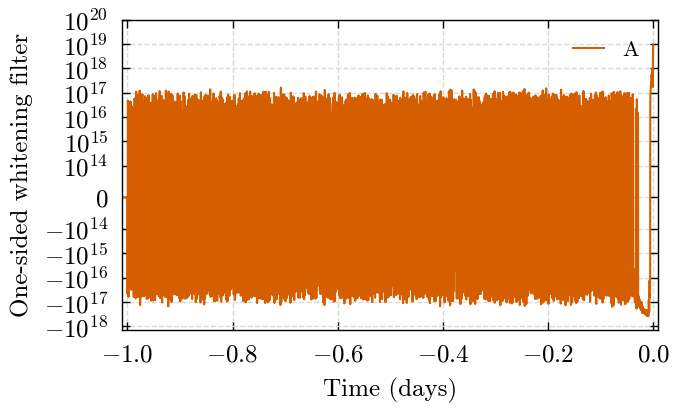

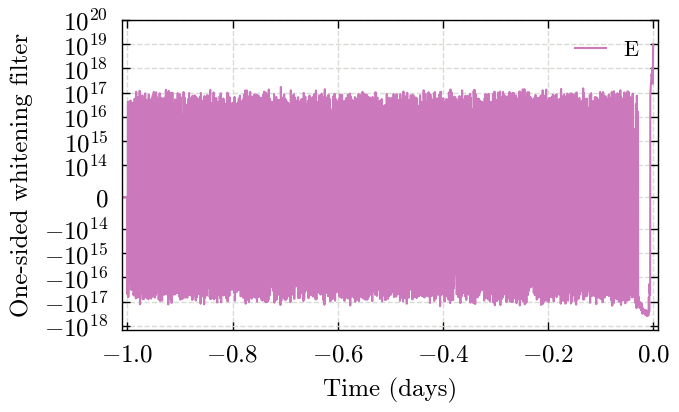

In [8]:
psd_vals = []

for psd_file, channel in psd_files:
    zero_phase_kern = \
        generate_pre_merger_psds(
            psd_file,
            duration=dlen,
            sample_rate=sample_rate,
            kernel_length=int(86400*sample_rate)
        )

    plt.figure()
    plt.semilogy(
        (zero_phase_kern['TD'].sample_times - zero_phase_kern['TD'].sample_times[-1])/86400,
        zero_phase_kern['TD'],
        label=channel,
        c=cycle[3] if channel == 'A' else cycle[4]
    )
    plt.legend(loc='upper right')
    plt.yscale('asinh', linear_width=1E13)
    plt.xlim(-1.01, 0.01)
    plt.xlabel('Time (days)')
    plt.ylabel('One-sided whitening filter')
    major_ticks = [
        -1E18, -1E17, -1E16, -1E15, -1E14, 0, 1E14, 1E15,
        1E16, 1E17, 1E18, 1E19, 1E20
        ]
    major_tick_labels = [
        "$-10^{18}$", "$-10^{17}$", "$-10^{16}$",
        "$-10^{15}$", "$-10^{14}$", "0", "$10^{14}$",
        "$10^{15}$", "$10^{16}$", "$10^{17}$", "$10^{18}$",
        "$10^{19}$", "$10^{20}$"
    ]
    plt.yticks(major_ticks, labels=major_tick_labels)  # Adjust labels as needed
    plt.minorticks_off()

    plt.grid(zorder=-100)
    psd_vals.append((
        zero_phase_kern['FD'].sample_frequencies,
        1./abs(zero_phase_kern['FD'])**2,
        f'{channel} (zero-latency)'
    ))


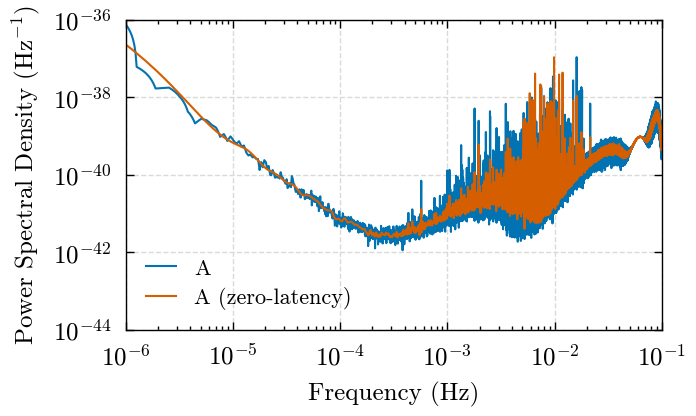

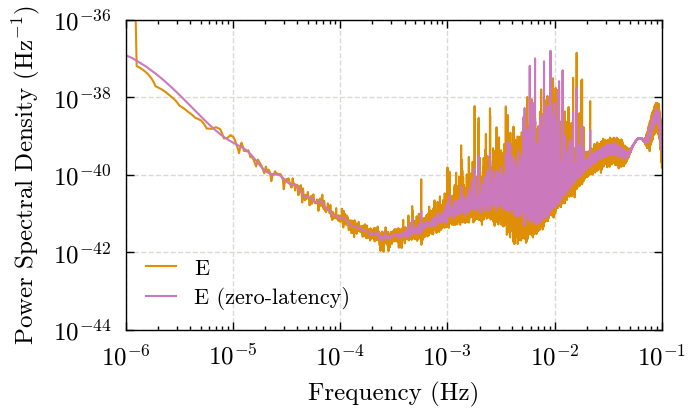

In [9]:


for i, vals in enumerate(psd_vals):
    plt.figure()
    plt.loglog(
        raw_smoothed[i].sample_frequencies,
        raw_smoothed[i],
        label=raw_labels[i],
        c=cycle[i]
    )
    plt.loglog(
        vals[0],
        vals[1],
        label=vals[2],
        c = cycle[i+3]
    )
    plt.legend(loc='lower left')
    plt.ylim([1E-44,1E-36])
    plt.xlim([1E-6,1E-1])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density ($\\mathrm{Hz}^{-1}$)')
    plt.grid(zorder=-100)